#CLEANING AND ASSESSING OSM DATASET

MELAKUKAN DATA ASSESSING PADA DATASET HASIL SCRAPING DARI OSM, BERIKUT HAL YANG SAYA LAKUKAN:


*   Mengambil kolom-kolom *addr:housenumber, addr:street, addr:suburb, addr:city* dan menggabungkannya menjadi 1 kolom yakni kolom *placeAddress* agar sama dengan dataset dari GMAPS (address bersifat opsional agar tidak ada yang *NULL*)
*   Mengambil *latitude* dan *longitude* lokasi dari elemen* node, way, relation* yang berupa *center* atau *geometry* untuk mengisi baris yang kolom *latitude* dan *longitude* nya kosong
* Menambah kolom *placeBussinessStatus* dengan asumsi semua bangunan masih beroperasi atau **OPERATIONAL**
* Menambah kolom *source* untuk label asal data yakni dari **OSM**
* Kolom lain hanya diganti nama kolomnya untuk generalisasi



In [112]:
import pandas as pd
import numpy as np
import ast
import json

In [113]:
!pip install rapidfuzz

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
from rapidfuzz import fuzz
from sklearn.neighbors import BallTree

In [115]:
with open('/content/drive/MyDrive/BPS_PROJECT/PRE-PROCESSED/osm.json') as f:
    dataOSM = json.load(f)

###PARSING HASIL SCRAPING

In [116]:
places = []
for element in dataOSM['elements']:
    tags = element.get('tags', {})
    place_id = f"osm{element['id']}"
    name = tags.get('name', 'Unknown')

    address_parts = [tags.get(k) for k in ['addr:housenumber', 'addr:street', 'addr:suburb', 'addr:city']]
    address = ', '.join([part for part in address_parts if part])

    lat = (
        element.get('lat') or
        element.get('center', {}).get('lat') or
        (element.get('geometry')[0]['lat'] if element.get('geometry') else None)
    )
    lon = (
        element.get('lon') or
        element.get('center', {}).get('lon') or
        (element.get('geometry')[0]['lon'] if element.get('geometry') else None)
    )

    types = []
    for k in ['amenity', 'shop', 'office']:
        if k in tags:
            types.append(tags[k])
    types.append("point_of_interest")
    types.append("establishment")

    places.append({
        'placeId': place_id,
        'placeName': name,
        'placeBusinessStatus': 'OPERATIONAL',
        'placeAddress': address,
        'placeTypes': ','.join(types),
        'placeLatitude': lat,
        'placeLongitude': lon,
        'source': 'OSM'
    })


In [117]:
dfOSM = pd.DataFrame(places)

In [118]:
dfOSM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              2580 non-null   object 
 1   placeName            2580 non-null   object 
 2   placeBusinessStatus  2580 non-null   object 
 3   placeAddress         2580 non-null   object 
 4   placeTypes           2580 non-null   object 
 5   placeLatitude        2580 non-null   float64
 6   placeLongitude       2580 non-null   float64
 7   source               2580 non-null   object 
dtypes: float64(2), object(6)
memory usage: 161.4+ KB


In [119]:
dfOSM.head(20)

,placeId,placeName,placeBusinessStatus,placeAddress,placeTypes,placeLatitude,placeLongitude,source
0,osm456045476,SPBU,OPERATIONAL,"Jl. H. Imam Munandar, Pekanbaru","fuel,point_of_interest,establishment",0.500350,101.471285,OSM
1,osm457837210,Pertamina,OPERATIONAL,,"fuel,point_of_interest,establishment",0.612717,101.428377,OSM
2,osm457837500,Pertamina,OPERATIONAL,,"fuel,point_of_interest,establishment",0.538436,101.402952,OSM
3,osm457837513,Pertamina,OPERATIONAL,,"fuel,point_of_interest,establishment",0.573834,101.398519,OSM
4,osm461577405,RM Sederhana Loket,OPERATIONAL,,"restaurant,point_of_interest,establishment",0.508595,101.444694,OSM
5,osm461802011,Ayam Goreng Suharti,OPERATIONAL,Jalan Riau,"restaurant,point_of_interest,establishment",0.535625,101.432480,OSM
6,osm462161178,Rumah Makan Minan Harapan,OPERATIONAL,,"restaurant,point_of_interest,establishment",0.491418,101.486844,OSM
7,osm462165004,SPBU,OPERATIONAL,,"fuel,point_of_interest,establishment",0.512301,101.395726,OSM
8,osm465135769,Bank Central Asia,OPERATIONAL,,"bank,point_of_interest,establishment",0.521243,101.447123,OSM
9,osm467530312,Pertamina,OPERATIONAL,,"fuel,point_of_interest,establishment",0.464999,101.526956,OSM


In [120]:
dfOSM.columns

Index(['placeId', 'placeName', 'placeBusinessStatus', 'placeAddress',
       'placeTypes', 'placeLatitude', 'placeLongitude', 'source'],
      dtype='object')

In [121]:
dfOSM.to_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/OSM_FINAL_CLEANED.xlsx")

#CLEANING AND ASSESSING GOOGLE MAPS DATASET

ADDING THE SOURCE COLUMN TO GMAPS DATASET

In [122]:
dataGM = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PRE-PROCESSED/SamplePlace_1471.xlsx")

In [123]:
dataGM.head()

,placeId,placeName,placeAddress,placeBusinessStatus,placeTypes,placeLatitude,placeLongitude
0,ChIJG0i9CEap1TERq1G-K3lxuus,Graha Renova,"GC2C+GP3, Tengkerang Barat",OPERATIONAL,"point_of_interest,establishment",0.501254,101.421803
1,ChIJI0kxnE-p1TERVzzCaVLc_-A,Putri Jaya Abadi. CV,"Jalan Musyawarah No.184, Labuh Baru Timur",OPERATIONAL,"furniture_store,home_goods_store,point_of_inte...",0.503969,101.423609
2,ChIJ75xs3BSp1TERjUD6T2Hr7MU,Warung Ojo Forget,"GC3G+GQ4, Jalan Soekarno-Hatta, Sidomulyo Timur",OPERATIONAL,"restaurant,point_of_interest,food,establishment",0.503770,101.426964
3,ChIJn_QB002p1TERjXQjpmobcjE,Batam Central Electronik,"Komplek Taman Anggrek Blok A4-6, Jl. Tuanku Ta...",OPERATIONAL,"electronics_store,point_of_interest,store,esta...",0.503697,101.428838
4,ChIJWxkAUdOp1TERTPhwfB11yBc,BOS (Bintang Oto Service),"Jalan Ikhlas, Labuh Baru Timur",OPERATIONAL,"car_repair,point_of_interest,establishment",0.505233,101.430264


In [124]:
dataGM.columns

Index(['placeId', 'placeName', 'placeAddress', 'placeBusinessStatus',
       'placeTypes', 'placeLatitude', 'placeLongitude'],
      dtype='object')

In [125]:
dataGM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40763 entries, 0 to 40762
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              40763 non-null  object 
 1   placeName            40763 non-null  object 
 2   placeAddress         40755 non-null  object 
 3   placeBusinessStatus  40760 non-null  object 
 4   placeTypes           40763 non-null  object 
 5   placeLatitude        40763 non-null  float64
 6   placeLongitude       40763 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.2+ MB


In [126]:
dataGM['placeAddress'] = dataGM['placeAddress'].fillna('')
dataGM['placeBusinessStatus'] = dataGM['placeBusinessStatus'].fillna('OPERATIONAL')

In [127]:
dataGM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40763 entries, 0 to 40762
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              40763 non-null  object 
 1   placeName            40763 non-null  object 
 2   placeAddress         40763 non-null  object 
 3   placeBusinessStatus  40763 non-null  object 
 4   placeTypes           40763 non-null  object 
 5   placeLatitude        40763 non-null  float64
 6   placeLongitude       40763 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.2+ MB


In [128]:
dataGM['source'] = 'GMAPS'

In [129]:
dataGM.head()

,placeId,placeName,placeAddress,placeBusinessStatus,placeTypes,placeLatitude,placeLongitude,source
0,ChIJG0i9CEap1TERq1G-K3lxuus,Graha Renova,"GC2C+GP3, Tengkerang Barat",OPERATIONAL,"point_of_interest,establishment",0.501254,101.421803,GMAPS
1,ChIJI0kxnE-p1TERVzzCaVLc_-A,Putri Jaya Abadi. CV,"Jalan Musyawarah No.184, Labuh Baru Timur",OPERATIONAL,"furniture_store,home_goods_store,point_of_inte...",0.503969,101.423609,GMAPS
2,ChIJ75xs3BSp1TERjUD6T2Hr7MU,Warung Ojo Forget,"GC3G+GQ4, Jalan Soekarno-Hatta, Sidomulyo Timur",OPERATIONAL,"restaurant,point_of_interest,food,establishment",0.503770,101.426964,GMAPS
3,ChIJn_QB002p1TERjXQjpmobcjE,Batam Central Electronik,"Komplek Taman Anggrek Blok A4-6, Jl. Tuanku Ta...",OPERATIONAL,"electronics_store,point_of_interest,store,esta...",0.503697,101.428838,GMAPS
4,ChIJWxkAUdOp1TERTPhwfB11yBc,BOS (Bintang Oto Service),"Jalan Ikhlas, Labuh Baru Timur",OPERATIONAL,"car_repair,point_of_interest,establishment",0.505233,101.430264,GMAPS


In [130]:
dataGM.to_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/GM_FINAL_CLEANED.xlsx", index=False)

#MERGING OSM AND GMAPS DATASET

In [131]:
gmaps = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/GM_FINAL_CLEANED.xlsx")
osm = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/OSM_FINAL_CLEANED.xlsx")

In [132]:
combined_df = pd.concat([gmaps, osm], ignore_index=True)

In [133]:
combined_df = combined_df.drop('Unnamed: 0', axis=1)

In [134]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43343 entries, 0 to 43342
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              43343 non-null  object 
 1   placeName            43343 non-null  object 
 2   placeAddress         41352 non-null  object 
 3   placeBusinessStatus  43343 non-null  object 
 4   placeTypes           43343 non-null  object 
 5   placeLatitude        43343 non-null  float64
 6   placeLongitude       43343 non-null  float64
 7   source               43343 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.6+ MB


In [135]:
combined_df['placeAddress'] = combined_df['placeAddress'].fillna('-')

In [136]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43343 entries, 0 to 43342
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              43343 non-null  object 
 1   placeName            43343 non-null  object 
 2   placeAddress         43343 non-null  object 
 3   placeBusinessStatus  43343 non-null  object 
 4   placeTypes           43343 non-null  object 
 5   placeLatitude        43343 non-null  float64
 6   placeLongitude       43343 non-null  float64
 7   source               43343 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.6+ MB


In [137]:
combined_df.to_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/merged.xlsx')

#DATA ASSESSING

* Memeriksa data dan mengecek apakah missing value, memeriksa apakah ada duplikasi
* Mengisi kolom atau mendrop baris yang memiliki missing value

In [138]:
print("Jumlah duplikasi: ", combined_df.duplicated().sum())

Jumlah duplikasi:  0


In [139]:
combined_df.isna().sum()

,0
placeId,0
placeName,0
placeAddress,0
placeBusinessStatus,0
placeTypes,0
placeLatitude,0
placeLongitude,0
source,0


In [140]:
combined_df.describe()

,placeLatitude,placeLongitude
count,43343.000000,43343.000000
mean,0.498549,101.433454
std,0.039780,0.038976
min,0.420513,101.332527
25%,0.467235,101.406718
50%,0.496659,101.435286
75%,0.524405,101.456568
max,0.680416,101.599236


In [141]:
for col in combined_df.select_dtypes(include='object'):
    combined_df[col] = combined_df[col].str.strip()

In [142]:
mask = combined_df['placeName'].str.contains(r'^[^a-zA-Z]*$', na=False)
df_clean = combined_df[~mask].reset_index(drop=True)

In [143]:
import re
import unicodedata

In [144]:
def clean_string(text):
    if pd.isna(text):
        return ""
    # 1. Normalisasi karakter unicode
    text = unicodedata.normalize('NFKC', str(text))
    # 2. Hapus karakter khusus yang berulang/berlebihan
    text = re.sub(r'[?]{2,}|[_]{2,}|[-]{2,}', ' ', text)
    # 3. Ganti simbol khusus di awal string
    text = re.sub(r'^[#@&]+', '', text)
    # 4. Pertahankan simbol di tengah string
    text = re.sub(r'([^\w\s&+/-]|(?<!\w)[&+/-](?!\w))', ' ', text)
    # 5. Bersihkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [145]:
def filter_invalid_rows(df):
    # Cari baris yang hanya berisi simbol/angka tanpa huruf
    mask = df['placeName'].str.contains(
        r'^[\s\W_]*$',
        na=True,
        regex=True
    )
    return df[~mask].reset_index(drop=True)

In [146]:
text_cols = ['placeName', 'placeAddress', 'placeTypes']
for col in text_cols:
    combined_df[col] = combined_df[col].apply(clean_string)
# Langkah 3: Filter baris tidak valid
df_clean = filter_invalid_rows(combined_df)

In [147]:
df_clean = df_clean[df_clean['placeName'].str.upper() != 'UNKNOWN']

In [148]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42924 entries, 0 to 43333
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              42924 non-null  object 
 1   placeName            42924 non-null  object 
 2   placeAddress         42924 non-null  object 
 3   placeBusinessStatus  42924 non-null  object 
 4   placeTypes           42924 non-null  object 
 5   placeLatitude        42924 non-null  float64
 6   placeLongitude       42924 non-null  float64
 7   source               42924 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.9+ MB


In [149]:
keywords_to_remove = [
    'masjid', 'mesjid', 'musholla', 'gereja', 'hkbp', 'candi', 'vihara', 'kuil',
    'pemakaman', 'makam', 'kuburan', 'lapangan', 'mosque', 'place_of_worship', 'church'
]
pattern = r'\b(?:' + '|'.join(keywords_to_remove) + r')\b'
initial_rows = len(df_clean)
mask_place_name = df_clean['placeName'].str.contains(pattern, case=False, na=False, regex=True)
mask_place_types = df_clean['placeTypes'].str.contains(pattern, case=False, na=False, regex=True)
combined_mask_to_remove = mask_place_name | mask_place_types
df_filtered = df_clean[~combined_mask_to_remove].copy()
removed_rows = initial_rows - len(df_filtered)

In [150]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41257 entries, 0 to 43333
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              41257 non-null  object 
 1   placeName            41257 non-null  object 
 2   placeAddress         41257 non-null  object 
 3   placeBusinessStatus  41257 non-null  object 
 4   placeTypes           41257 non-null  object 
 5   placeLatitude        41257 non-null  float64
 6   placeLongitude       41257 non-null  float64
 7   source               41257 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.8+ MB


In [151]:
df_filtered.to_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/cleaned_data.xlsx', index=False)

#MENGECEK DUPLIKASI BERDASARKAN LOKASI / JARAK ANTAR POIN

In [152]:
# !pip install fuzzywuzzy rapidfuzz

####CLUSTERING BERDASARKAN KEDEKATAN LOKASI DAN NAMA TEMPAT SAMA (MELIHAT JARAK ANTAR DUPLIKASI)

**100M atau 1KM**

In [153]:
TRESHOLD = 200.0
NAME_SIM = 70

In [154]:
def check_nearby(df, TRESHOLD, NAME_SIM):
    df = df.copy()
    df['normalizedName'] = df['placeName'].str.lower().str.strip()
    r_earth = 6371000
    coords = np.deg2rad(df[['placeLatitude', 'placeLongitude']])
    tree = BallTree(coords, metric='haversine')
    neighbors = tree.query_radius(coords, r=TRESHOLD/r_earth)

    clusters = []
    processed = set()
    for idx, nearby_indices in enumerate(neighbors):
        if idx in processed:
            continue
        current_name = df.iloc[idx]['normalizedName']
        cluster = [idx]

        for neighbor_idx in nearby_indices:
            if neighbor_idx == idx or neighbor_idx in processed:
                continue
            neighbor_name = df.iloc[neighbor_idx]['normalizedName']
            similarity = fuzz.token_sort_ratio(
                current_name,
                neighbor_name
            )
            if similarity >= NAME_SIM:
                cluster.append(neighbor_idx)
                processed.add(neighbor_idx)
        if len(cluster) > 1:
            clusters.append(cluster)
            processed.add(idx)
    return clusters

In [155]:
def merge_clusters(df, clusters):
    mergedrows = []
    clustered_indices = set()

    for cluster in clusters:
        clustered_indices.update(cluster)
        first_row = df.iloc[cluster[0]].copy()
        first_row['placeLatitude'] = df.iloc[cluster]['placeLatitude'].mean()
        first_row['placeLongitude'] = df.iloc[cluster]['placeLongitude'].mean()
        mergedrows.append(first_row)
    non_clustered = df[~df.index.isin(list(clustered_indices))]
    return pd.concat([non_clustered, pd.DataFrame(mergedrows)], ignore_index=True)

In [156]:
print("Memuat data bersih...")
df = pd.read_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/cleaned_data.xlsx')


Memuat data bersih...


In [157]:
clusters = check_nearby(df, TRESHOLD, NAME_SIM)

In [158]:
final = merge_clusters(df, clusters)

In [159]:
final['placeAddress'] = final['placeAddress'].fillna('-')

In [160]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39833 entries, 0 to 39832
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              39833 non-null  object 
 1   placeName            39833 non-null  object 
 2   placeAddress         39833 non-null  object 
 3   placeBusinessStatus  39833 non-null  object 
 4   placeTypes           39833 non-null  object 
 5   placeLatitude        39833 non-null  float64
 6   placeLongitude       39833 non-null  float64
 7   source               39833 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.4+ MB


In [161]:
final.to_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/final_data.xlsx', index=False)

#VISUALISASI PERBEDAAN SEBELUM DAN SESUDAH PEMBERSIHAN DATASET

In [162]:
df_raw = pd.read_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/merged.xlsx')
df_cleaned = pd.read_excel('/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/final_data.xlsx')

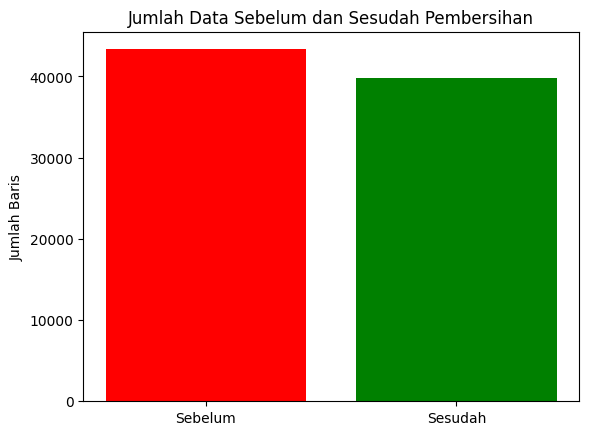

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns


counts = [len(df_raw), len(df_cleaned)]
labels = ['Sebelum', 'Sesudah']
plt.bar(labels, counts, color=['red', 'green'])
plt.title("Jumlah Data Sebelum dan Sesudah Pembersihan")
plt.ylabel("Jumlah Baris")
plt.show()

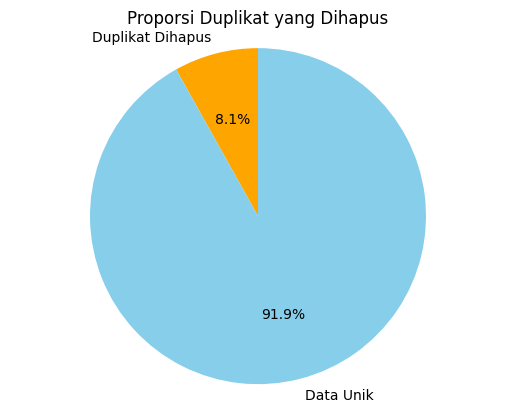

In [164]:
dups_removed = len(df_raw) - len(df_cleaned)
plt.pie([dups_removed, len(df_cleaned)], labels=['Duplikat Dihapus', 'Data Unik'],
        autopct='%1.1f%%', colors=['orange', 'skyblue'], startangle=90)
plt.title("Proporsi Duplikat yang Dihapus")
plt.axis('equal')
plt.show()

<ipython-input-166-d4d76a84012c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.index, y=source_counts.values, palette='viridis')


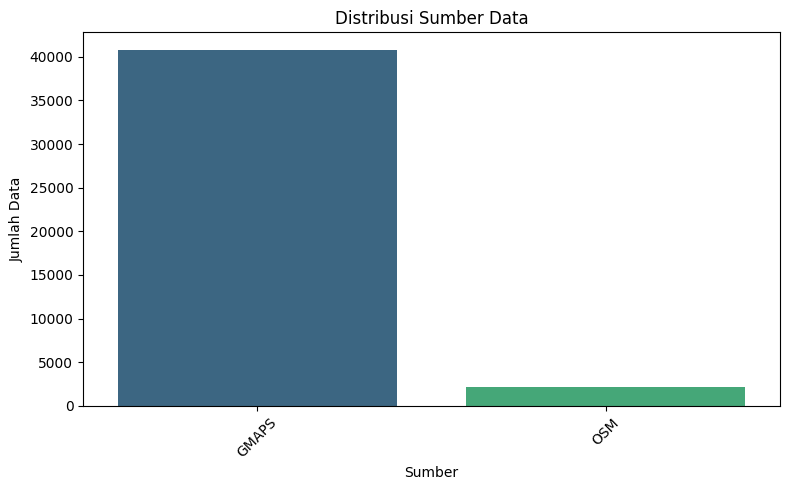

In [166]:
source_counts = df_clean['source'].value_counts()
# Plot distribusi
plt.figure(figsize=(8, 5))
sns.barplot(x=source_counts.index, y=source_counts.values, palette='viridis')
plt.title("Distribusi Sumber Data")
plt.xlabel("Sumber")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()